In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import optuna
import itertools
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
import re
from wordcloud import WordCloud

In [97]:
import optuna
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [3]:
nltk.download("vader_lexicon")
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv("D:\\Projects\\Fake News Detection\\Data\\News Dataset.csv")

In [5]:
def pre_process(df):
    """
    Pre-processes a DataFrame by converting specific columns to string type,
    encoding the 'label' column, and separating the DataFrame into two parts.

    This function performs several preprocessing steps on the input DataFrame:
    1. Converts the 'title' and 'text' columns to string type to ensure consistency.
    2. Encodes the 'label' column, mapping 'FAKE' to 1 and 'REAL' to 0, to prepare for machine learning algorithms.
    3. Drops the 'Unnamed: 0' column which is often an artifact from reading files with an index.
    4. Splits the DataFrame into two separate DataFrames: one containing 'title' and 'label' columns, and the other containing 'text' and 'label' columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be pre-processed.

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]: A tuple of two DataFrames. The first DataFrame contains 'title' and 'label' columns,
      and the second DataFrame contains 'text' and 'label' columns.
    """
    # Ensure 'title' and 'text' columns are of string type
    columns = ["title", "text"]
    for col in columns:
        df[col] = df[col].astype(str)  # Convert each column to string

    # Map 'label' values from 'FAKE'/'REAL' to 1/0
    df["label"] = df["label"].map({"FAKE": 1, "REAL": 0})

    # Remove the 'Unnamed: 0' column, if it exists, as it's usually an artifact
    df = df.drop(["Unnamed: 0"], axis=1)

    # Split the DataFrame into two: one with 'title' and 'label', and one with 'text' and 'label'
    df_title = df[["title", "label"]]
    df_text = df[["text", "label"]]

    # Define the directory where you want to save the pickle files
    directory_path = "D:\\Projects\\Fake News Detection\\Data\\"

    # Export df_title as a pickle file
    # df_title.to_pickle(directory_path + "df_title.pkl")

    # Export df_text as a pickle file
    # df_text.to_pickle(directory_path + "df_text.pkl")

    print("DataFrames exported as pickle files successfully.")

    return df_title, df_text

In [6]:
def num_characters(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of characters in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """

    df["Characters"] = df[col_name].apply(len)
    return df


def num_sentences(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of sentences in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Sentences"] = df[col_name].apply(lambda x: len(nltk.sent_tokenize(x)))
    return df


def num_words(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of words in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Words"] = df[col_name].apply(lambda x: len(nltk.word_tokenize(x)))
    return df

In [7]:
def pie_plot(df, col_name):
    """
    Creates a pie plot to show the distribution of real and fake news in the DataFrame.

    Parameters:
    - df: DataFrame. The DataFrame containing the data.
    - col_name: str. The name of the column containing the labels.

    Returns:
    - None. Displays a pie plot.
    """
    sizes = df["label"].value_counts()
    labels = ["Real", "Fake"]
    colors = ["#ff9999", "#66b3ff"]

    plt.pie(
        sizes,
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        explode=(0.1, 0),
        shadow=True,
    )

    plt.title("Distribution of Real and Fake News in " + col_name)
    plt.legend(labels, title="News Type", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

In [8]:
def plot_distribution_features(df, features, col_name):
    """
    Plot distributions of specified features in a DataFrame, comparing 'Real' and 'Fake' news.

    Parameters:
    - df: DataFrame containing the data.
    - features: List of strings, names of the columns for which to plot the distributions.

    Each feature's distribution is plotted in a separate row, with 'Real' news in blue and 'Fake' news in pink.
    """
    # Create a figure with subplots arranged in 3 rows and 1 column
    fig, axes = plt.subplots(
        nrows=len(features), ncols=1, figsize=(15, 6 * len(features))
    )

    for i, feature in enumerate(features):
        # Plot distribution for 'Real' news
        sns.histplot(
            df[df["label"] == 0][feature],
            kde=True,
            color="#66b3ff",
            label="Real",
            ax=axes[i],
        )
        # Plot distribution for 'Fake' news
        sns.histplot(
            df[df["label"] == 1][feature],
            kde=True,
            color="#ff9999",
            label="Fake",
            ax=axes[i],
        )
        # Setting the title for each subplot
        axes[i].set_title(f"{feature} Distribution for {col_name} dataset")
        # Setting the labels for each subplot
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Count")
        # Adding legend to each subplot
        axes[i].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [9]:
def plot_mean_median(df, features, col_name):
    """
    Plot the mean and median of specified features in a DataFrame, comparing 'Real' and 'Fake' news.

    Parameters:
    - df: DataFrame containing the data.
    - features: List of strings, names of the columns for which to plot the mean and median.
    - col_name: The name of the column to be used in the title of plots.

    Each feature's mean and median are plotted in separate subplots, with 'Real' news in one color and 'Fake' news in another.
    """
    # Ensure features are numeric for mean/median calculation
    for feature in features:
        df[feature] = pd.to_numeric(df[feature], errors="coerce")

    # Create a figure with subplots
    fig, axes = plt.subplots(
        nrows=len(features), ncols=1, figsize=(10, 5 * len(features))
    )

    # Check if we have more than one feature to plot, if not, wrap axes in a list
    if len(features) == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        # Prepare a DataFrame with mean and median values for both labels
        summary_df = (
            df.groupby("label")[feature]
            .agg(["mean", "median"])
            .reset_index()
            .melt(id_vars="label")
        )

        # Plot
        sns.barplot(
            x="label",
            y="value",
            hue="variable",
            data=summary_df,
            ax=axes[i],
            palette="coolwarm",
        )
        axes[i].set_title(f"Mean and Median of {feature} for {col_name}")
        axes[i].set_xlabel("Label")
        axes[i].set_ylabel(f"{feature} Count")
        axes[i].legend(title="Statistic")

    plt.tight_layout()
    plt.show()

In [10]:
def process_text(text):
    # Convert text to lower case
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Removing special characters
    tokens = [re.sub(r"[^a-zA-Z0-9]", "", token) for token in tokens]
    tokens = [token for token in tokens if token]  # Remove empty strings

    # Removing stop words and punctuation
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

In [11]:
def analyze_sentiment(text):
    if not isinstance(text, str):
        raise ValueError("Input must be a string")

    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)

    if score["compound"] >= 0.05:
        return "positive"
    elif score["compound"] <= -0.05:
        return "negative"
    else:
        return "neutral"

In [12]:
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [13]:
df_title, df_text = pre_process(df)

DataFrames exported as pickle files successfully.


EDA

In [14]:
df_title

,title,label
0,You Can Smell Hillary’s Fear,1
1,Watch The Exact Moment Paul Ryan Committed Pol...,1
2,Kerry to go to Paris in gesture of sympathy,0
3,Bernie supporters on Twitter erupt in anger ag...,1
4,The Battle of New York: Why This Primary Matters,0
...,...,...
6330,State Department says it can't find emails fro...,0
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1
6332,Anti-Trump Protesters Are Tools of the Oligarc...,1
6333,"In Ethiopia, Obama seeks progress on peace, se...",0


In [15]:
df_title = num_characters(df_title, "title")
df_title = num_sentences(df_title, "title")
df_title = num_words(df_title, "title")

In [16]:
df_text = num_characters(df_text, "text")
df_text = num_sentences(df_text, "text")
df_text = num_words(df_text, "text")

In [17]:
df_title

,title,label,Characters,Sentences,Words
0,You Can Smell Hillary’s Fear,1,28,1,7
1,Watch The Exact Moment Paul Ryan Committed Pol...,1,85,1,16
2,Kerry to go to Paris in gesture of sympathy,0,43,1,9
3,Bernie supporters on Twitter erupt in anger ag...,1,84,1,18
4,The Battle of New York: Why This Primary Matters,0,48,1,10
...,...,...,...,...,...
6330,State Department says it can't find emails fro...,0,69,1,12
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1,59,1,16
6332,Anti-Trump Protesters Are Tools of the Oligarc...,1,66,1,9
6333,"In Ethiopia, Obama seeks progress on peace, se...",0,67,1,13


In [18]:
df_text

,text,label,Characters,Sentences,Words
0,"Daniel Greenfield, a Shillman Journalism Fello...",1,7518,87,1473
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,2646,26,517
2,U.S. Secretary of State John F. Kerry said Mon...,0,2543,16,484
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,2660,17,498
4,It's primary day in New York and front-runners...,0,1840,21,376
...,...,...,...,...,...
6330,The State Department told the Republican Natio...,0,4076,27,726
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1,14323,49,2594
6332,Anti-Trump Protesters Are Tools of the Oligar...,1,11974,100,2137
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",0,6991,40,1313


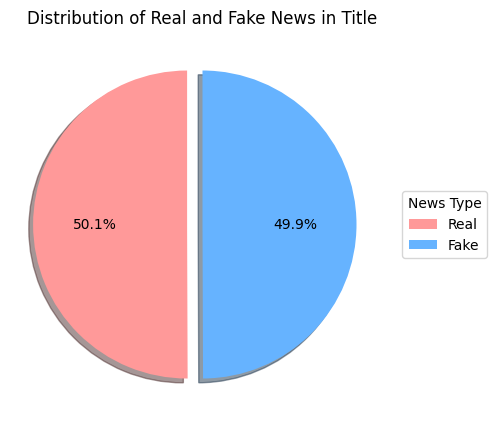

In [19]:
pie_plot(df_title, "Title")

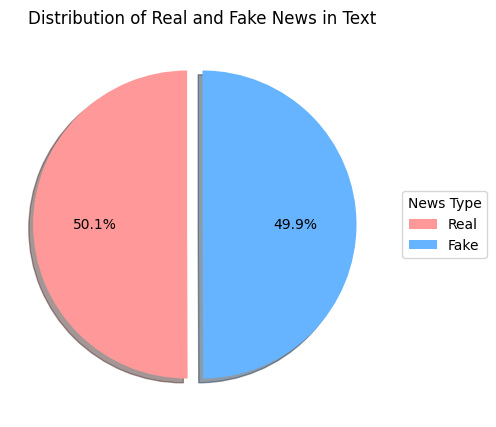

In [20]:
pie_plot(df_text, "Text")

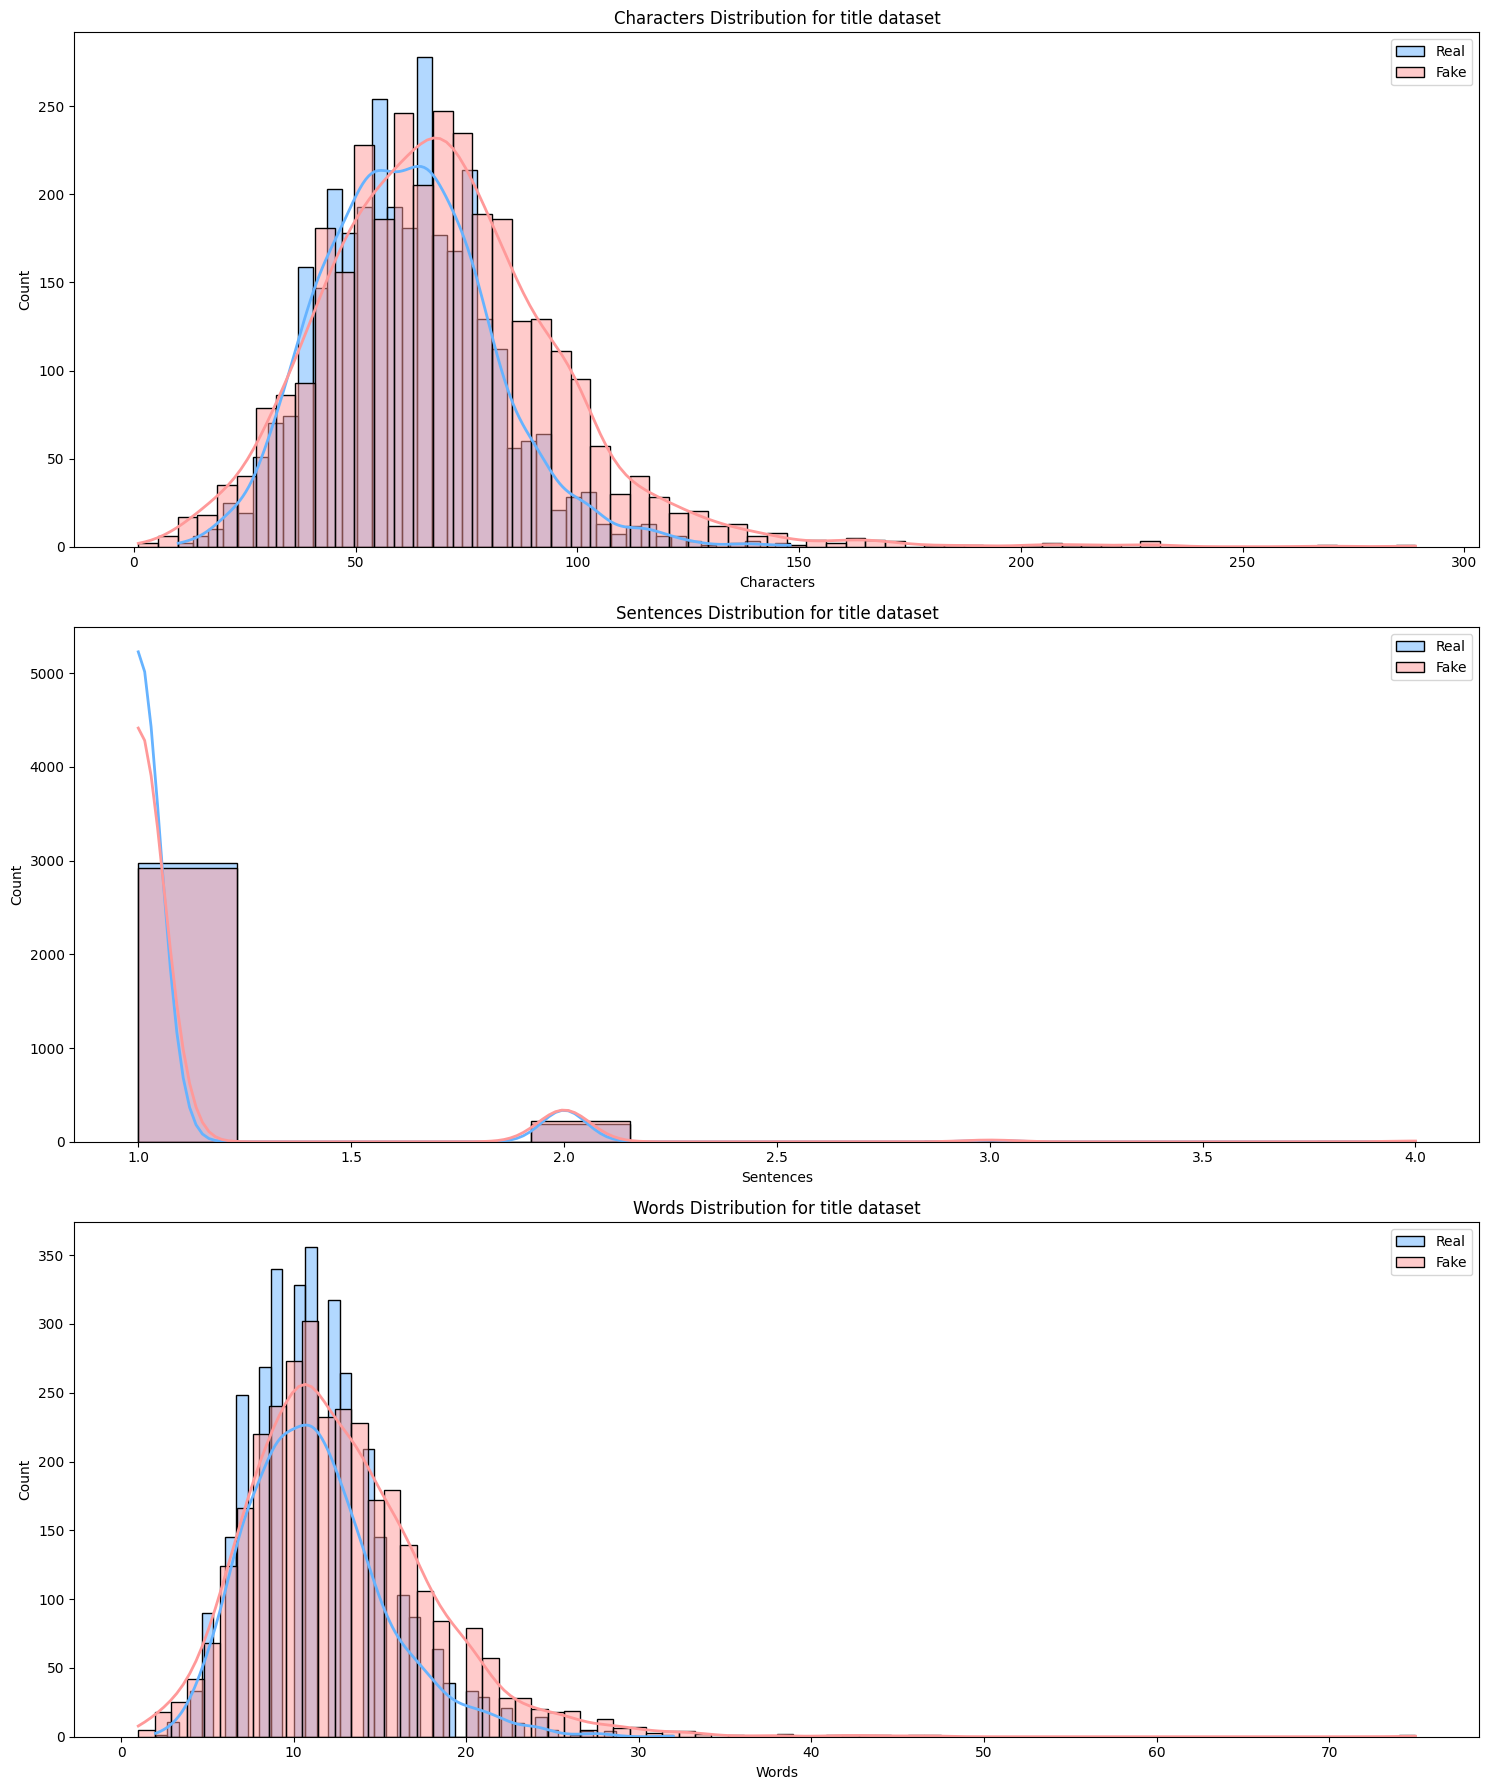

In [21]:
plot_distribution_features(df_title, ["Characters", "Sentences", "Words"], "title")

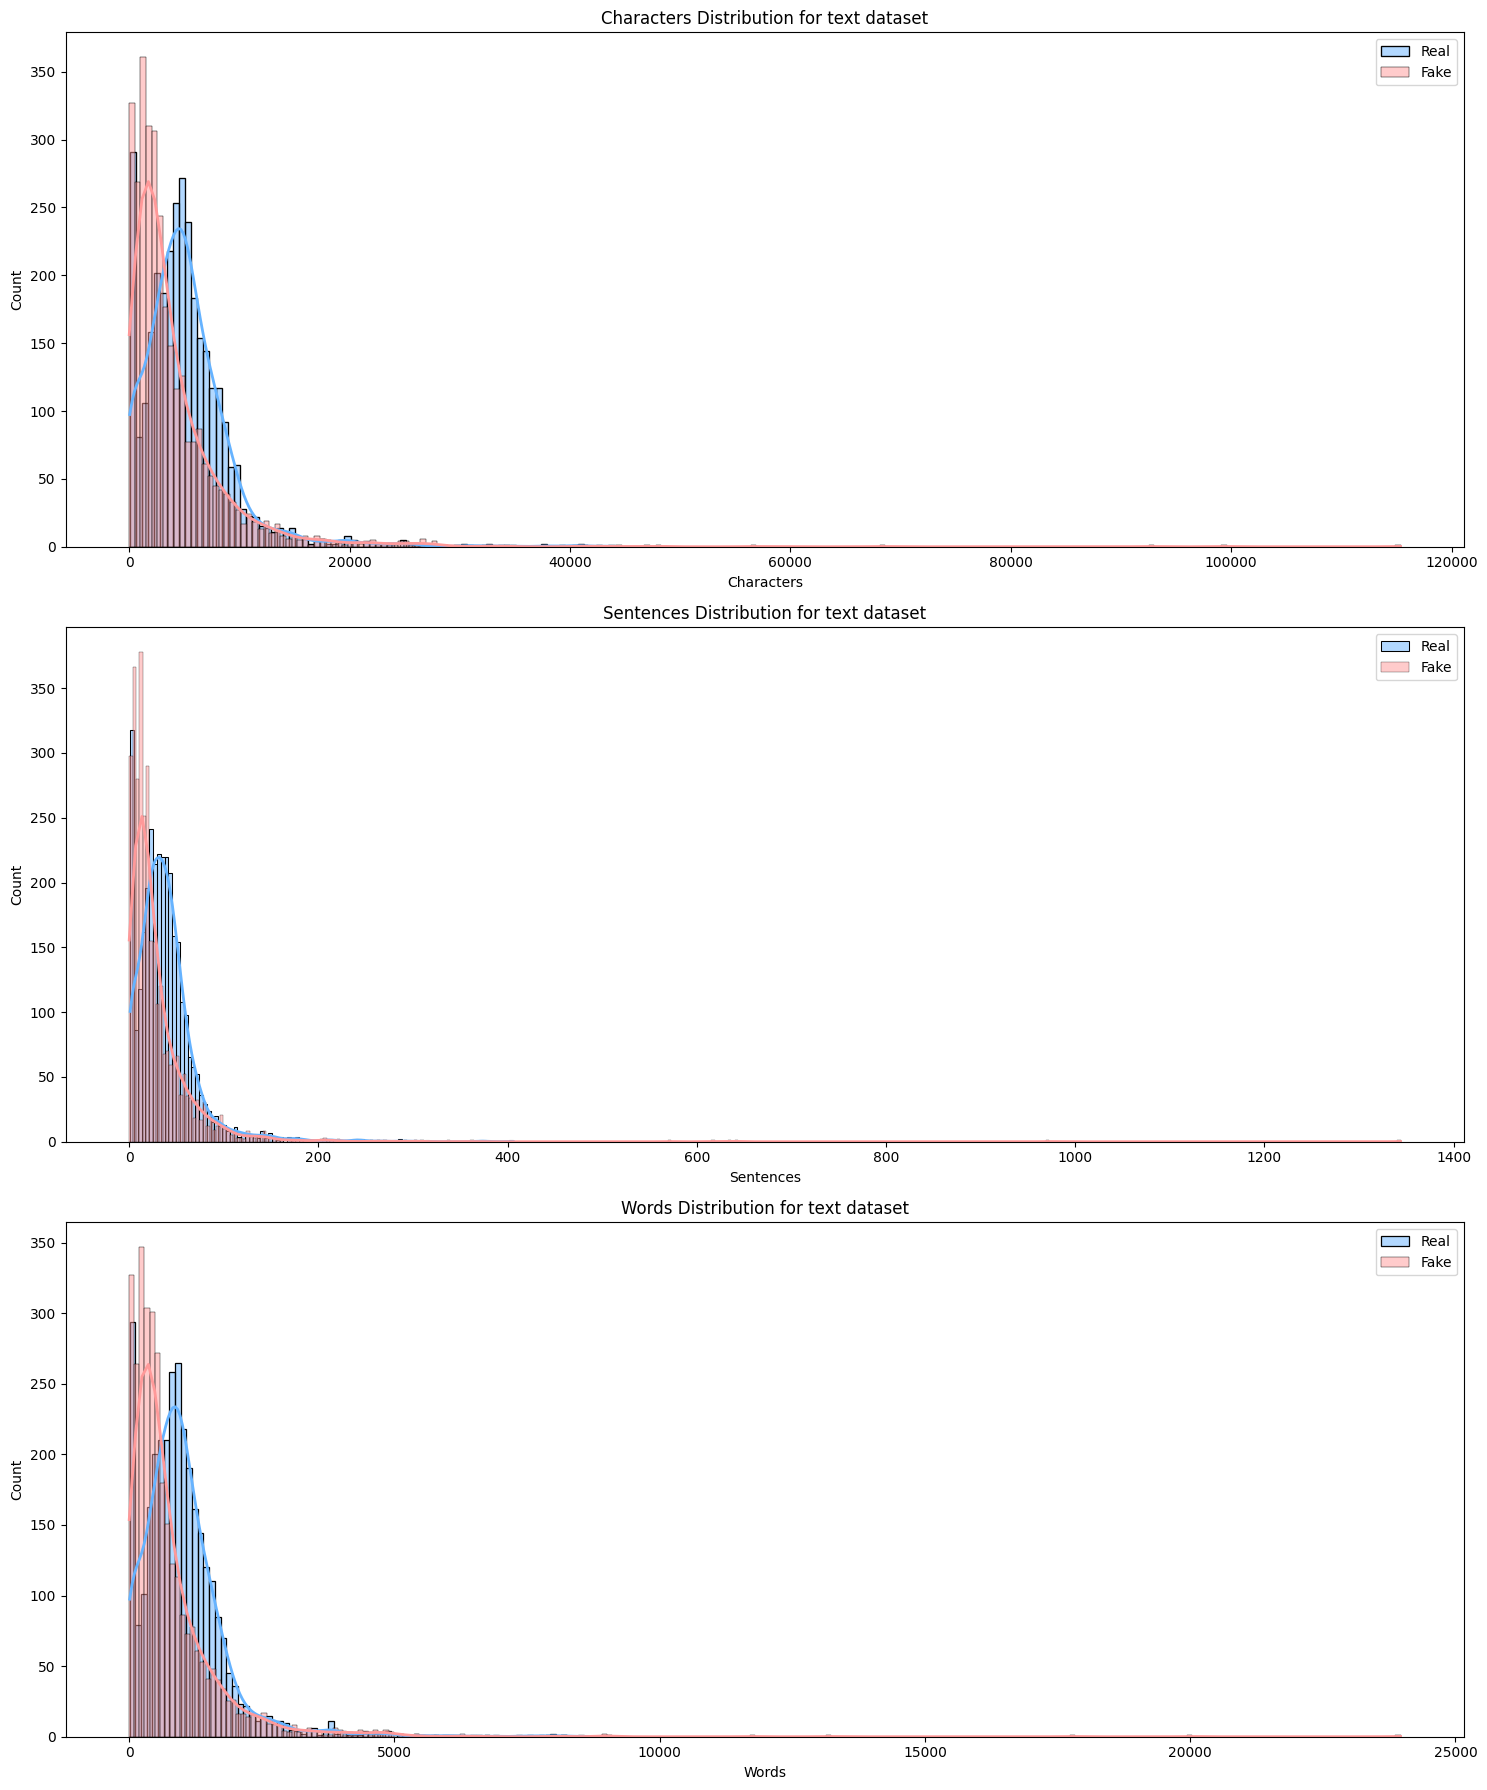

In [22]:
plot_distribution_features(df_text, ["Characters", "Sentences", "Words"], "text")

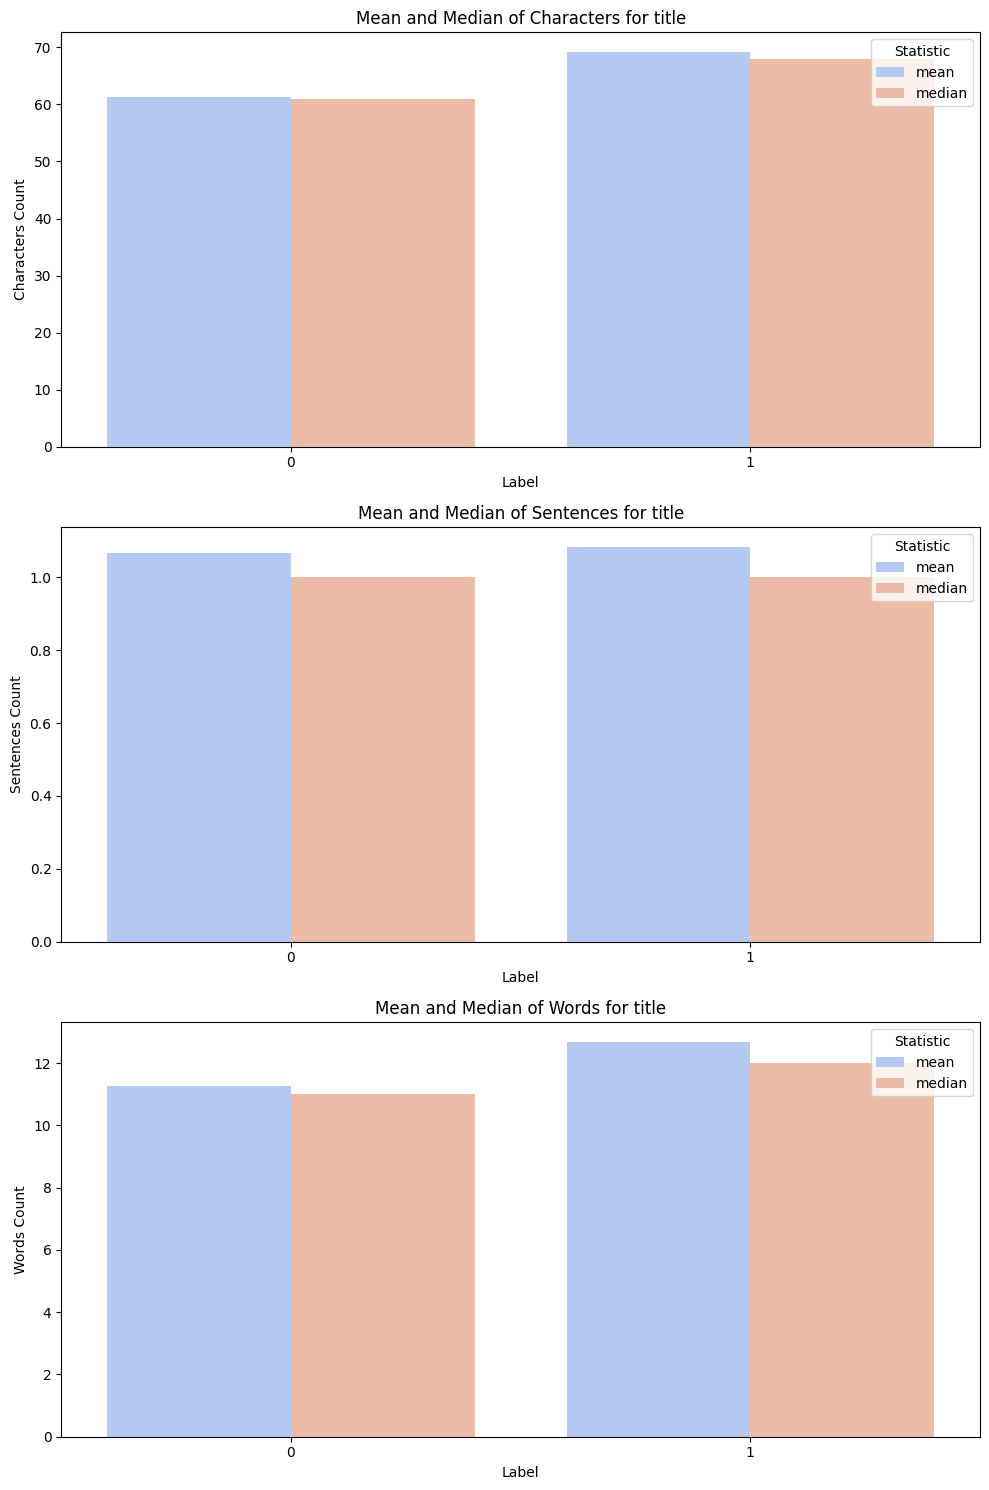

In [23]:
plot_mean_median(df_title, ["Characters", "Sentences", "Words"], "title")

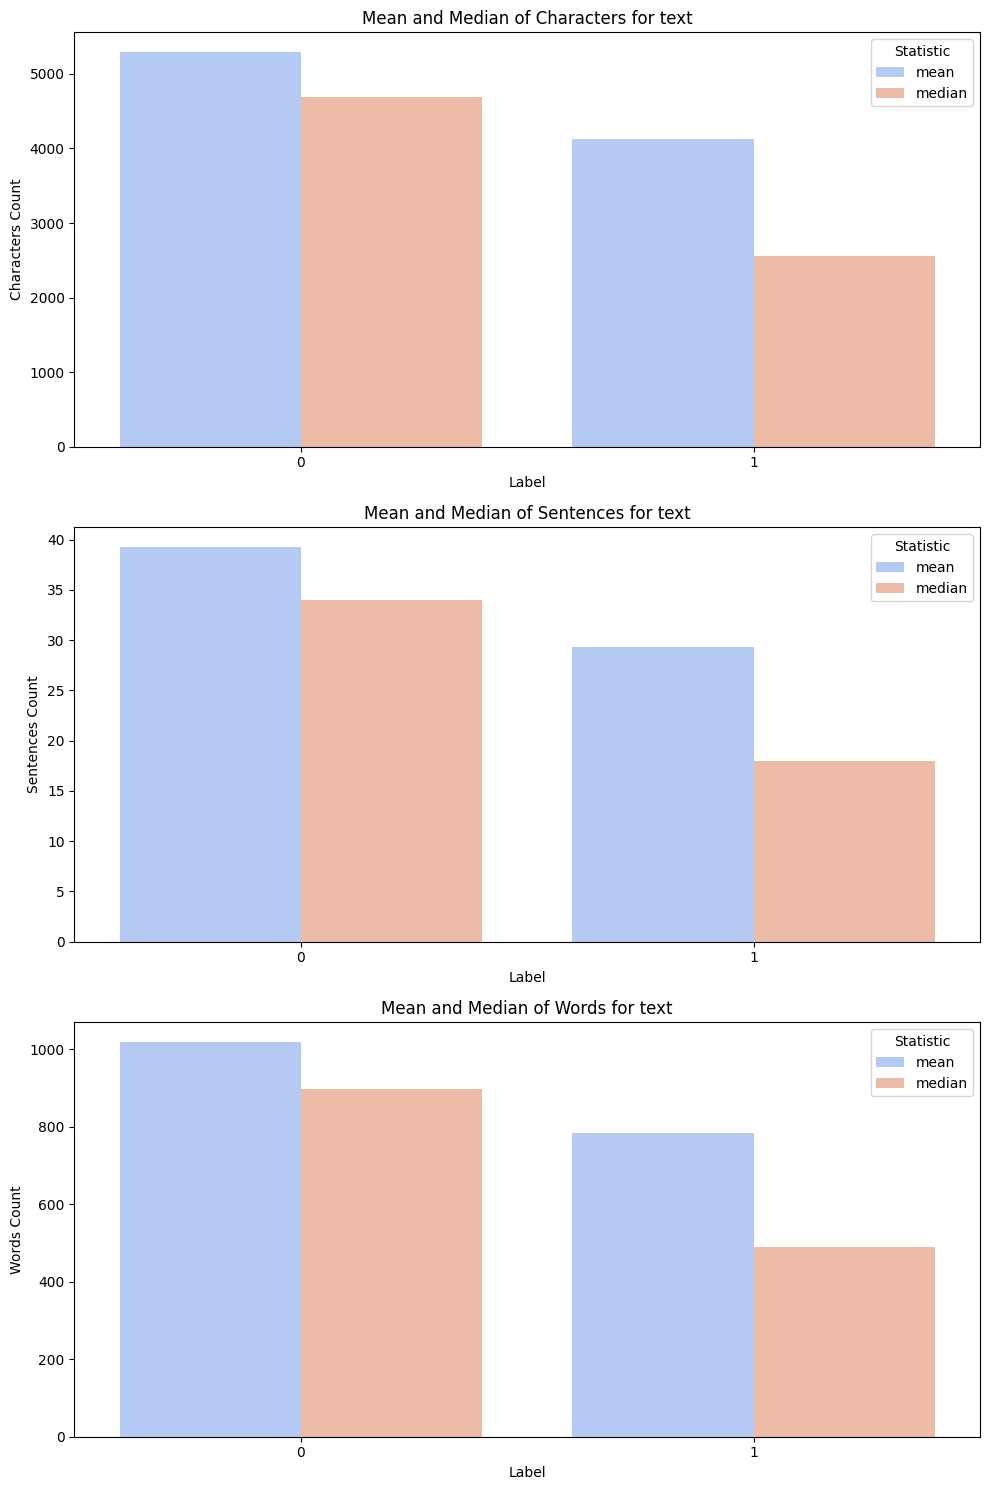

In [24]:
plot_mean_median(df_text, ["Characters", "Sentences", "Words"], "text")

In [25]:
df_title["Processed"] = df_title["title"].apply(process_text)

In [26]:
df_text["Processed"] = df_text["text"].apply(process_text)

In [27]:
df_text

,text,label,Characters,Sentences,Words,Processed
0,"Daniel Greenfield, a Shillman Journalism Fello...",1,7518,87,1473,"[daniel, greenfield, shillman, journal, fellow..."
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,2646,26,517,"[googl, pinterest, digg, linkedin, reddit, stu..."
2,U.S. Secretary of State John F. Kerry said Mon...,0,2543,16,484,"[us, secretari, state, john, f, kerri, said, m..."
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,2660,17,498,"[kayde, king, kaydeek, novemb, 9, 2016, lesson..."
4,It's primary day in New York and front-runners...,0,1840,21,376,"[primari, day, new, york, frontrunn, hillari, ..."
...,...,...,...,...,...,...
6330,The State Department told the Republican Natio...,0,4076,27,726,"[state, depart, told, republican, nation, comm..."
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1,14323,49,2594,"[p, pb, stand, plutocrat, pentagon, post, oct,..."
6332,Anti-Trump Protesters Are Tools of the Oligar...,1,11974,100,2137,"[antitrump, protest, tool, oligarchi, reform, ..."
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",0,6991,40,1313,"[addi, ababa, ethiopia, presid, obama, conven,..."


In [28]:
df_title

,title,label,Characters,Sentences,Words,Processed
0,You Can Smell Hillary’s Fear,1,28,1,7,"[smell, hillari, fear]"
1,Watch The Exact Moment Paul Ryan Committed Pol...,1,85,1,16,"[watch, exact, moment, paul, ryan, commit, pol..."
2,Kerry to go to Paris in gesture of sympathy,0,43,1,9,"[kerri, go, pari, gestur, sympathi]"
3,Bernie supporters on Twitter erupt in anger ag...,1,84,1,18,"[berni, support, twitter, erupt, anger, dnc, t..."
4,The Battle of New York: Why This Primary Matters,0,48,1,10,"[battl, new, york, primari, matter]"
...,...,...,...,...,...,...
6330,State Department says it can't find emails fro...,0,69,1,12,"[state, depart, say, ca, nt, find, email, clin..."
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1,59,1,16,"[p, pb, stand, plutocrat, pentagon]"
6332,Anti-Trump Protesters Are Tools of the Oligarc...,1,66,1,9,"[antitrump, protest, tool, oligarchi, inform]"
6333,"In Ethiopia, Obama seeks progress on peace, se...",0,67,1,13,"[ethiopia, obama, seek, progress, peac, secur,..."


In [29]:
df_title["Sentiment"] = df_title["title"].apply(analyze_sentiment)

In [30]:
df_text["Sentiment"] = df_text["text"].apply(analyze_sentiment)

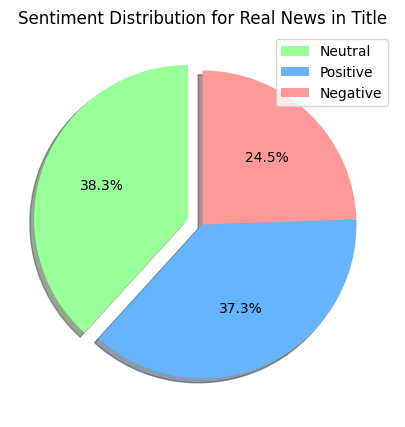

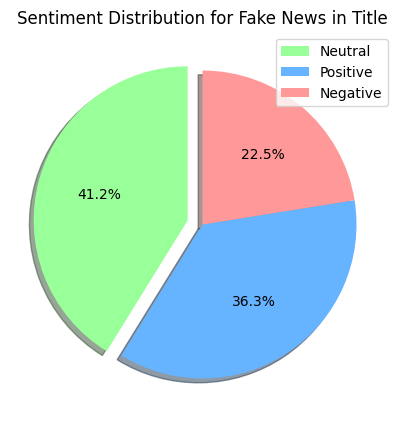

In [31]:
plt.pie(
    df_title[df_title["label"] == 0]["Sentiment"].value_counts(),
    autopct="%1.1f%%",
    colors=["#99ff99", "#66b3ff", "#ff9999"],
    startangle=90,
    explode=(0.1, 0, 0),
    shadow=True,
)
plt.legend(labels=["Neutral", "Positive", "Negative"])
plt.title("Sentiment Distribution for Real News in Title")
plt.show()
plt.clf()
plt.pie(
    df_title[df_title["label"] == 1]["Sentiment"].value_counts(),
    autopct="%1.1f%%",
    colors=["#99ff99", "#66b3ff", "#ff9999"],
    startangle=90,
    explode=(0.1, 0, 0),
    shadow=True,
)
plt.legend(labels=["Neutral", "Positive", "Negative"])
plt.title("Sentiment Distribution for Fake News in Title")
plt.show()

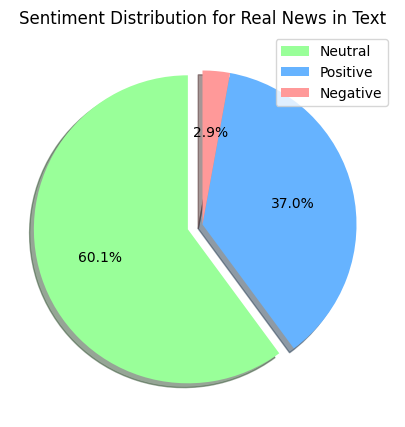

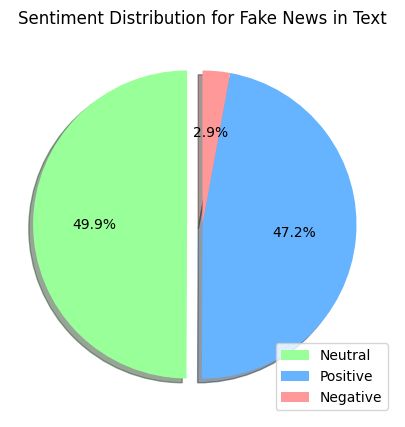

In [32]:
plt.pie(
    df_text[df_text["label"] == 0]["Sentiment"].value_counts(),
    autopct="%1.1f%%",
    colors=["#99ff99", "#66b3ff", "#ff9999"],
    startangle=90,
    explode=(0.1, 0, 0),
    shadow=True,
)
plt.legend(labels=["Neutral", "Positive", "Negative"])
plt.title("Sentiment Distribution for Real News in Text")
plt.show()
plt.clf()
plt.pie(
    df_text[df_text["label"] == 1]["Sentiment"].value_counts(),
    autopct="%1.1f%%",
    colors=["#99ff99", "#66b3ff", "#ff9999"],
    startangle=90,
    explode=(0.1, 0, 0),
    shadow=True,
)
plt.legend(labels=["Neutral", "Positive", "Negative"])
plt.title("Sentiment Distribution for Fake News in Text")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_18680\715136158.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
C:\Users\user\AppData\Local\Temp\ipykernel_18680\715136158.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


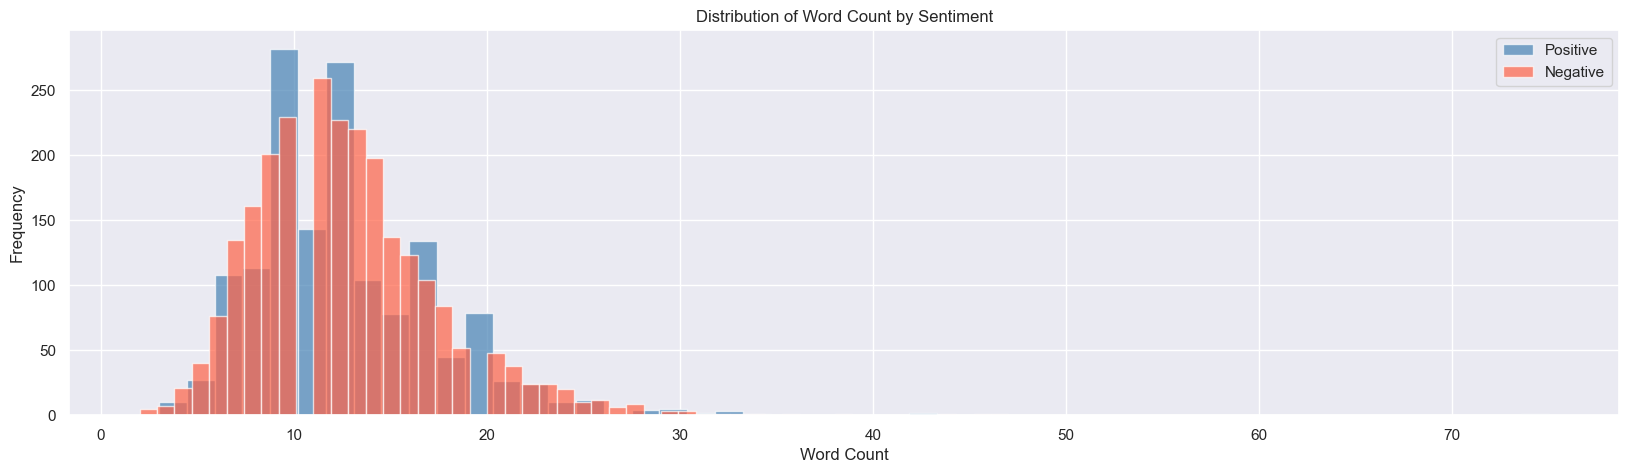

In [33]:
sns.set(style="darkgrid", palette="muted", color_codes=True)

positive_reviews = df_title[df_title["Sentiment"] == "positive"]
negative_reviews = df_title[df_title["Sentiment"] == "negative"]

sns.distplot(
    positive_reviews["Words"],
    color="steelblue",
    label="Positive",
    kde=False,
    hist_kws={"alpha": 0.7},
)
sns.distplot(
    negative_reviews["Words"],
    color="tomato",
    label="Negative",
    kde=False,
    hist_kws={"alpha": 0.7},
)

plt.title("Distribution of Word Count by Sentiment")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()

C:\Users\user\AppData\Local\Temp\ipykernel_18680\111030206.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
C:\Users\user\AppData\Local\Temp\ipykernel_18680\111030206.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


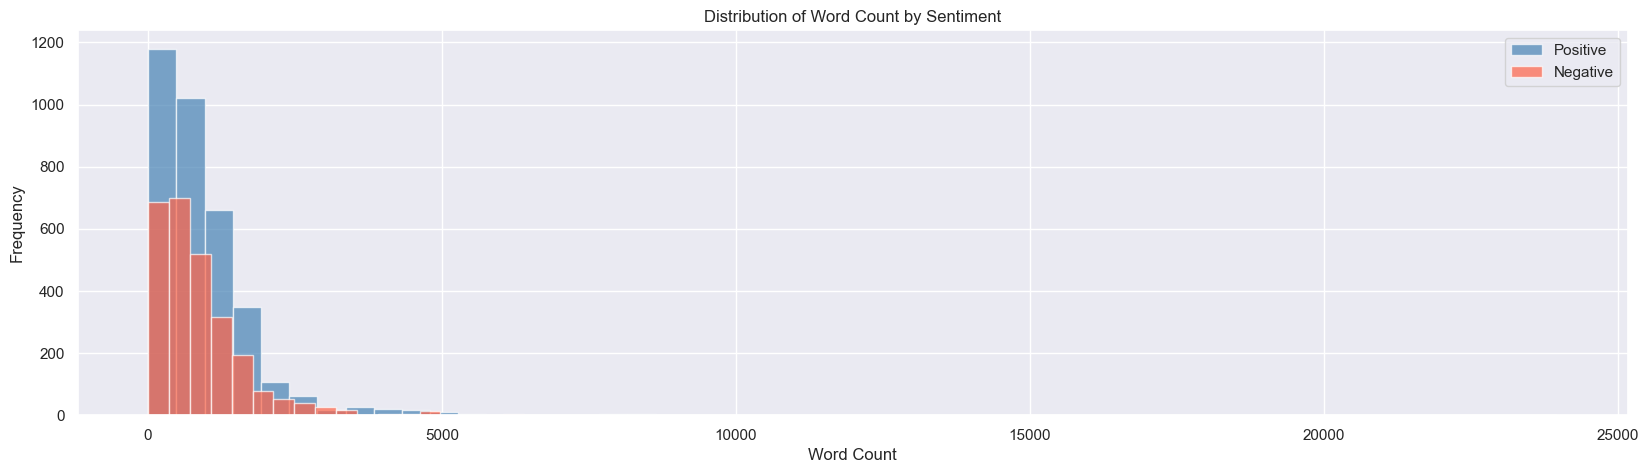

In [34]:
sns.set(style="darkgrid", palette="muted", color_codes=True)

positive_reviews = df_text[df_text["Sentiment"] == "positive"]
negative_reviews = df_text[df_text["Sentiment"] == "negative"]

sns.distplot(
    positive_reviews["Words"],
    color="steelblue",
    label="Positive",
    kde=False,
    hist_kws={"alpha": 0.7},
)
sns.distplot(
    negative_reviews["Words"],
    color="tomato",
    label="Negative",
    kde=False,
    hist_kws={"alpha": 0.7},
)

plt.title("Distribution of Word Count by Sentiment")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()

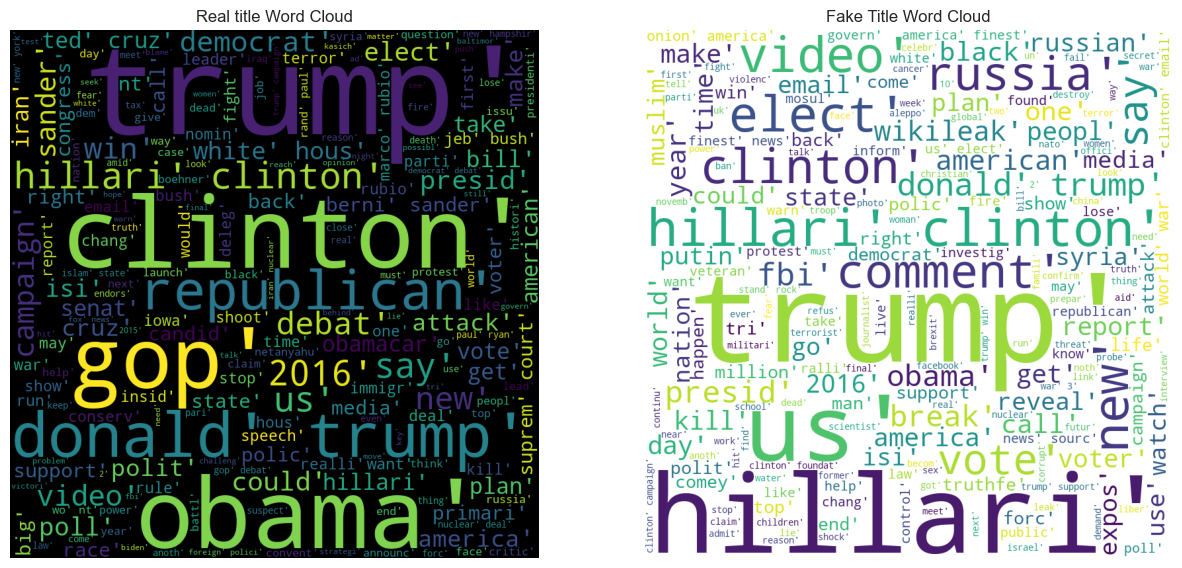

In [35]:
Real_title = df_title[df_title["label"] == 0]["Processed"].astype(str).str.cat(sep=" ")
Fake_title = df_title[df_title["label"] == 1]["Processed"].astype(str).str.cat(sep=" ")

spam_wc = WordCloud(
    width=800, height=800, background_color="black", stopwords=None, min_font_size=10
).generate(Real_title)

ham_wc = WordCloud(
    width=800, height=800, background_color="white", stopwords=None, min_font_size=10
).generate(Fake_title)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(spam_wc)
plt.title("Real title Word Cloud")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(ham_wc)
plt.title("Fake Title Word Cloud")
plt.axis("off")
plt.show()

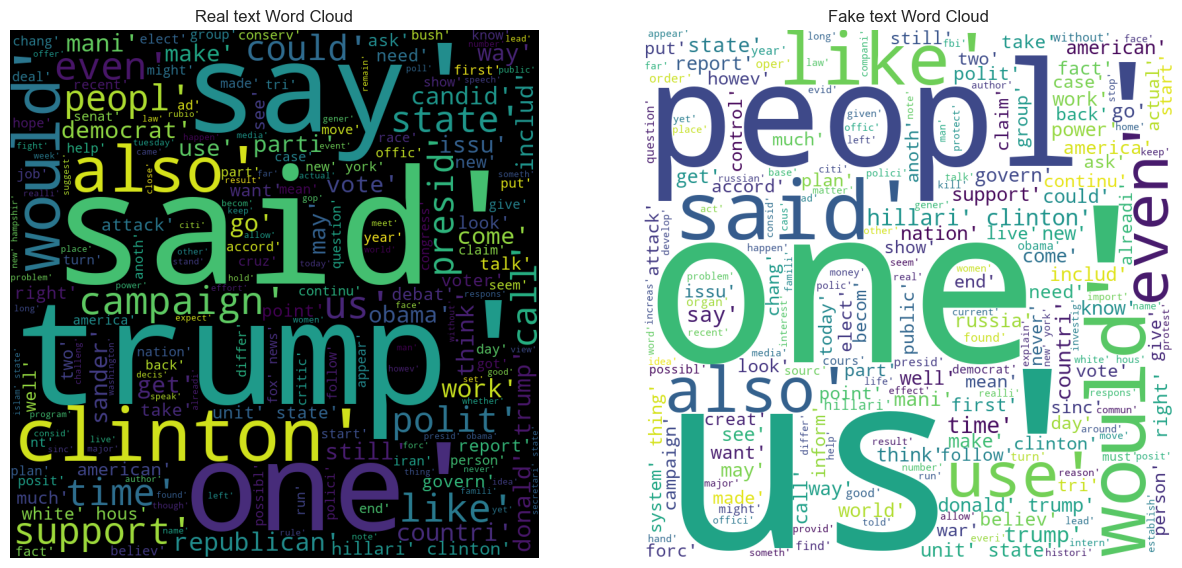

In [36]:
Real_title = df_text[df_text["label"] == 0]["Processed"].astype(str).str.cat(sep=" ")
Fake_title = df_text[df_text["label"] == 1]["Processed"].astype(str).str.cat(sep=" ")

spam_wc = WordCloud(
    width=800, height=800, background_color="black", stopwords=None, min_font_size=10
).generate(Real_title)

ham_wc = WordCloud(
    width=800, height=800, background_color="white", stopwords=None, min_font_size=10
).generate(Fake_title)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(spam_wc)
plt.title("Real text Word Cloud")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(ham_wc)
plt.title("Fake text Word Cloud")
plt.axis("off")
plt.show()

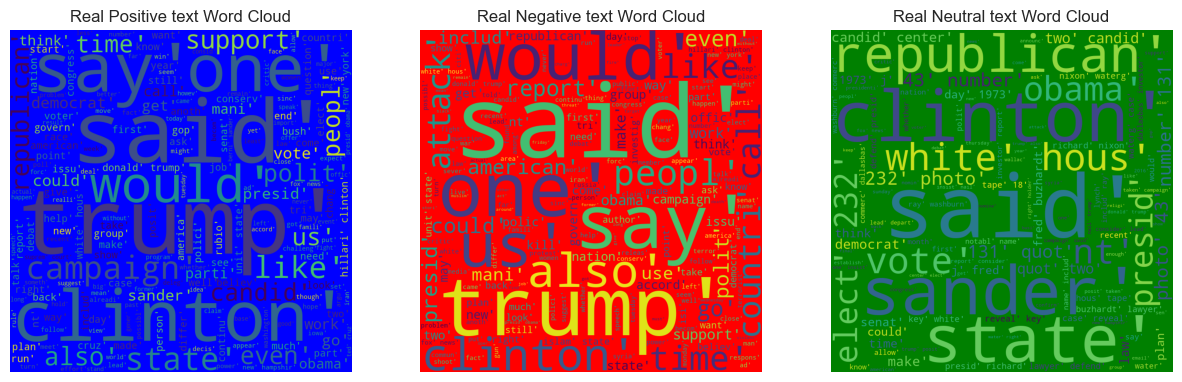

In [37]:
Real_text_postive = (
    df_text[(df_text["label"] == 0) & (df_text["Sentiment"] == "positive")]["Processed"]
    .astype(str)
    .str.cat(sep=" ")
)
Real_text_negative = (
    df_text[(df_text["label"] == 0) & (df_text["Sentiment"] == "negative")]["Processed"]
    .astype(str)
    .str.cat(sep=" ")
)
Real_text_neutral = (
    df_text[(df_text["label"] == 0) & (df_text["Sentiment"] == "neutral")]["Processed"]
    .astype(str)
    .str.cat(sep=" ")
)
Real_wc_p = WordCloud(
    width=800, height=800, background_color="blue", stopwords=None, min_font_size=10
).generate(Real_text_postive)

Real_wc_n = WordCloud(
    width=800, height=800, background_color="red", stopwords=None, min_font_size=10
).generate(Real_text_negative)
Real_wc_nu = WordCloud(
    width=800, height=800, background_color="green", stopwords=None, min_font_size=10
).generate(Real_text_neutral)

plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.imshow(Real_wc_p)
plt.title("Real Positive text Word Cloud")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(Real_wc_n)
plt.title("Real Negative text Word Cloud")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(Real_wc_nu)
plt.title("Real Neutral text Word Cloud")
plt.axis("off")
plt.show()

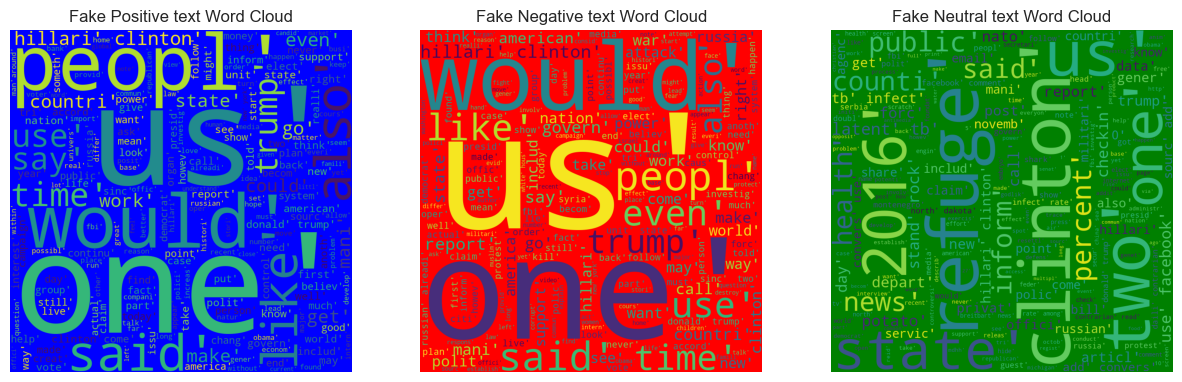

In [38]:
Real_text_postive = (
    df_text[(df_text["label"] == 1) & (df_text["Sentiment"] == "positive")]["Processed"]
    .astype(str)
    .str.cat(sep=" ")
)
Real_text_negative = (
    df_text[(df_text["label"] == 1) & (df_text["Sentiment"] == "negative")]["Processed"]
    .astype(str)
    .str.cat(sep=" ")
)
Real_text_neutral = (
    df_text[(df_text["label"] == 1) & (df_text["Sentiment"] == "neutral")]["Processed"]
    .astype(str)
    .str.cat(sep=" ")
)
Real_wc_p = WordCloud(
    width=800, height=800, background_color="blue", stopwords=None, min_font_size=10
).generate(Real_text_postive)

Real_wc_n = WordCloud(
    width=800, height=800, background_color="red", stopwords=None, min_font_size=10
).generate(Real_text_negative)
Real_wc_nu = WordCloud(
    width=800, height=800, background_color="green", stopwords=None, min_font_size=10
).generate(Real_text_neutral)

plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.imshow(Real_wc_p)
plt.title("Fake Positive text Word Cloud")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(Real_wc_n)
plt.title("Fake Negative text Word Cloud")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(Real_wc_nu)
plt.title("Fake Neutral text Word Cloud")
plt.axis("off")
plt.show()

In [49]:
df_title

,title,label,Characters,Sentences,Words,Processed,Sentiment
0,You Can Smell Hillary’s Fear,1,28,1,7,"[smell, hillari, fear]",negative
1,Watch The Exact Moment Paul Ryan Committed Pol...,1,85,1,16,"[watch, exact, moment, paul, ryan, commit, pol...",negative
2,Kerry to go to Paris in gesture of sympathy,0,43,1,9,"[kerri, go, pari, gestur, sympathi]",positive
3,Bernie supporters on Twitter erupt in anger ag...,1,84,1,18,"[berni, support, twitter, erupt, anger, dnc, t...",negative
4,The Battle of New York: Why This Primary Matters,0,48,1,10,"[battl, new, york, primari, matter]",negative
...,...,...,...,...,...,...,...
6330,State Department says it can't find emails fro...,0,69,1,12,"[state, depart, say, ca, nt, find, email, clin...",neutral
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1,59,1,16,"[p, pb, stand, plutocrat, pentagon]",neutral
6332,Anti-Trump Protesters Are Tools of the Oligarc...,1,66,1,9,"[antitrump, protest, tool, oligarchi, inform]",negative
6333,"In Ethiopia, Obama seeks progress on peace, se...",0,67,1,13,"[ethiopia, obama, seek, progress, peac, secur,...",positive


Model Building

In [82]:
def optimize_bnb(trial, X_train, X_test, y_train, y_test):
    alpha = trial.suggest_float("alpha", 1e-4, 10.0)
    binarize = trial.suggest_float("binarize", 0.0, 1.0)
    fit_prior = trial.suggest_categorical("fit_prior", [True, False])
    model = BernoulliNB(alpha=alpha, binarize=binarize, fit_prior=fit_prior)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return accuracy_score(y_test, predictions)

In [99]:
def optimize_xgb(trial, X_train, y_train, X_valid, y_valid):
    params = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "tree_method": "exact",  # Change to 'gpu_hist' for GPU
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.5),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    return accuracy

In [84]:
def plot_confusion_matrix(cm, classes, title="Confusion matrix"):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.grid(False)
    plt.show()

In [85]:
tfidf = TfidfVectorizer(max_features=3000)

In [86]:
X1 = df_title["Processed"].astype(str)
y1 = df_title["label"]
X2 = df_text["Processed"].astype(str)
y2 = df_text["label"]

In [ ]:
x

In [87]:
X1 = tfidf.fit_transform(X1).toarray()
X2 = tfidf.fit_transform(X2).toarray()

In [88]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

In [89]:
title_model = optuna.create_study(direction="maximize")
title_model.optimize(
    lambda trial: optimize_bnb(trial, X1_train, X1_test, y1_train, y1_test),
    n_trials=100,
)

[I 2024-03-23 04:18:59,122] A new study created in memory with name: no-name-4337b1ce-6a96-4aef-b4c9-96496878de24


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\

In [90]:
import optuna.visualization as ov



optimization_history = ov.plot_optimization_history(title_model)


optimization_history.show()

In [91]:
text_model = optuna.create_study(direction="maximize")
text_model.optimize(
    lambda trial: optimize_bnb(trial, X2_train, X2_test, y2_train, y2_test),
    n_trials=100,
)

[I 2024-03-23 04:20:43,602] A new study created in memory with name: no-name-d1f89959-516c-460b-8a88-a7d1beac333a
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [92]:
optimization_history = ov.plot_optimization_history(text_model)
optimization_history.show()

In [101]:
y2_train

1142    0
2654    1
5395    1
1170    1
4371    1
       ..
3772    0
5191    1
5226    1
5390    0
860     1
Name: label, Length: 5068, dtype: int64

In [114]:
XGb_model = optuna.create_study(direction="maximize")
XGb_model.optimize(
    lambda trial: optimize_xgb(trial, X2_train, y2_train, X2_test, y2_test),
    n_trials=25,
)

[I 2024-03-23 05:06:39,066] A new study created in memory with name: no-name-489b8104-a1bf-47d2-a311-9e736857c705
C:\Users\user\AppData\Local\Temp\ipykernel_18680\2999826900.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\user\AppData\Local\Temp\ipykernel_18680\2999826900.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages

In [115]:
optimization_history = ov.plot_optimization_history(XGb_model)
optimization_history.show()

In [116]:
best_params = XGb_model.best_params

In [117]:
best_params = XGb_model.best_params
XGb_model = xgb.XGBClassifier(**best_params)
XGb_model.fit(X2_train, y2_train)
y2_pred = XGb_model.predict(X2_test)
print("Accuracy: ", accuracy_score(y2_test, y2_pred))
print("Precision: ", precision_score(y2_test, y2_pred))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Accuracy:  0.9352801894238358
Precision:  0.9347133757961783


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



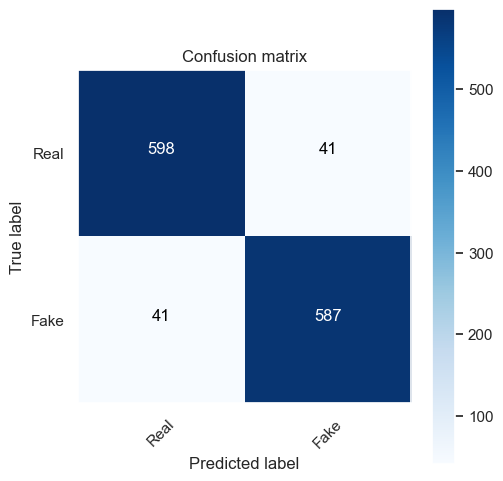

Confusion Matrix XgBoost:  [[598  41]
 [ 41 587]]


In [121]:
cm = confusion_matrix(y2_test, y2_pred)
classes = ["Real", "Fake"]
plot_confusion_matrix(cm, classes)
print("Confusion Matrix XgBoost: ", cm)

In [93]:
best_params = title_model.best_params

model = BernoulliNB(
    alpha=best_params["alpha"],
    binarize=best_params["binarize"],
    fit_prior=best_params["fit_prior"],
)

model.fit(X1_train, y1_train)


y_pred = model.predict(X1_test)
print("Accuracy: ", accuracy_score(y1_test, y_pred))
print("Precision: ", precision_score(y1_test, y_pred))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Accuracy:  0.823993685872139
Precision:  0.827140549273021


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



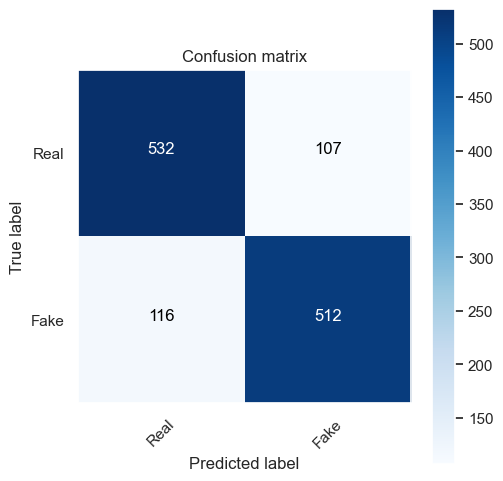

In [94]:
cm = confusion_matrix(y1_test, y_pred)
classes = ["Real", "Fake"]
plot_confusion_matrix(cm, classes)

In [108]:
best_params = text_model.best_params

model_text = BernoulliNB(
    alpha=best_params["alpha"],
    binarize=best_params["binarize"],
    fit_prior=best_params["fit_prior"],
)

model_text.fit(X2_train, y2_train)


y_pred = model_text.predict(X2_test)
print("Accuracy: ", accuracy_score(y2_test, y_pred))
print("Precision: ", precision_score(y2_test, y_pred))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Accuracy:  0.8823993685872139
Precision:  0.8645357686453576


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



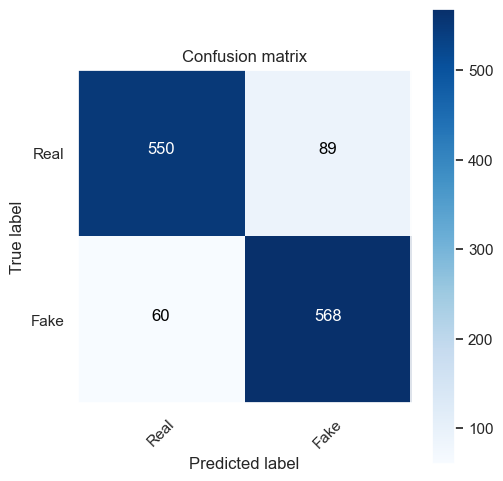

In [109]:
cm = confusion_matrix(y2_test, y_pred)
classes = ["Real", "Fake"]
plot_confusion_matrix(cm, classes)

In [122]:
pickle.dump(XGb_model, open("Xgb_model.pkl", "wb"))
pickle.dump(model, open("title_model.pkl", "wb"))